# Tutorial de Aprendizaje Automatizado Naive Bayes con plantcv

El ingenuo enfoque multiclase de Bayes es una extensión del enfoque ingenuo de Bayes. Se puede entrenar para generar imágenes binarias dada una imagen de color de entrada. A diferencia del método Bayes ingenuo, el enfoque multiclase Bayes ingenuo puede ser entrenado para clasificar dos o más clases, definidas por el usuario. Además, el ingenuo método multiclase de Bayes se entrena utilizando colores escasamente muestreados de imágenes en lugar de la necesidad de etiquetar todos los píxeles en una imagen dada.
Para entrenar al clasificador, necesitamos construir una tabla de valores de color rojo, verde y azul para los píxeles muestreados uniformemente de cada clase. La idea aquí es recopilar una muestra relevante de datos de color de píxeles para cada clase. El tamaño de la muestra necesaria para construir funciones de densidad de probabilidad robustas para cada clase dependerá de una serie de factores, incluida la variabilidad en los colores de la clase y la calidad / reproducibilidad de la imagen. Para recopilar datos de color de píxeles, actualmente utilizamos la herramienta de inspección de píxeles en [ImageJ](https://imagej.nih.gov/ij/). Cada columna de la tabla delimitada por tabulaciones es una clase de entidad (en este ejemplo, planta, pústula, clorosis o fondo) y cada celda es un triplete rojo, verde y azul separado por comas para un píxel.


Una vez que se haya recopilado una muestra satisfactoria de píxeles, guarde la tabla como un archivo de texto delimitado por tabulaciones. Utilice `plantcv-train.py` para  utilizar los ejemplos de píxeles para generar funciones de densidad de probabilidad (PDF o FDP) para cada clase.

plantcv-train.py naive_bayes_multiclass --file pixel_samples.txt --outfile naive_bayes_pdfs.txt --plots

### Ejemplo
python3 plantcv-train.py naive_bayes_multiclass --file pixeles_tizon_imagej.txt --outfile ./img/naive_bayes_pdfs.txt --plots

El archivo de salida de `plantcv-train.py`contendrá una fila para cada canal de color (tono, saturación y valor) para cada clase. La primera y segunda columna son la clase y la etiqueta de canal, respectivamente. Las 256 columnas restantes contienen el valor p de los PDF para cada valor de intensidad observable en una imagen de 8 bits (0-255).

Una vez tengamos el archivo de salida `plantcv-train.py`, podremos clasificar píxeles en una imagen en color en PlantCV. En la imagen de ejemplo para este tutorial ya hemos recopilado píxeles y creado las funciones de densidad de probabilidad para cada clase.

In [ ]:
#%pip install plantcv

In [2]:
# Import libraries

import cv2
from plantcv import plantcv as pcv


### SE CORRE PREVIAMENTE DESDE LA CONSOLA PARA ENTRENAR AL MODEL
### Se corre

`plantcv-train.py` 

In [4]:
class options:
    def __init__(self):
        self.image = "./img/1_1.jpg"
        self.debug = "plot"
        self.writeimg= False 
        self.result = "ml_tutorial_results.json"
        self.outdir = "."

# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug


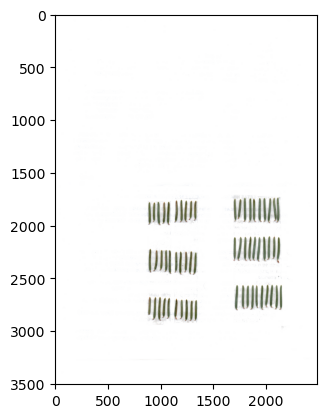

In [5]:
# Read image 

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)


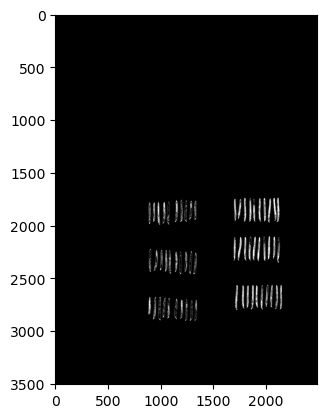

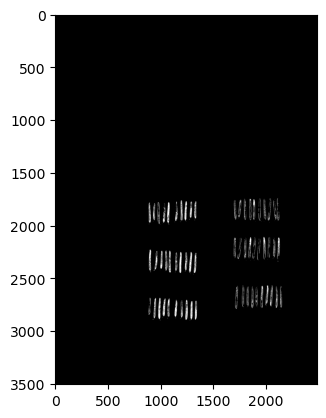

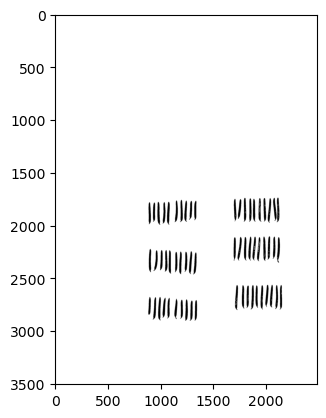

In [12]:
# Use the output file from `plantcv-train.py` to run the multiclass 
# naive bayes classification on the image. The function below will 
# print out 4 masks (plant, pustule, chlorosis, background)

# Inputs: 
#   rgb_img - RGB image data 
#   pdf_file - Output file containing PDFs from `plantcv-train.py`
mask = pcv.naive_bayes_classifier(rgb_img=img, 
                                  pdf_file="./img/naive_bayes_pdfs.txt")


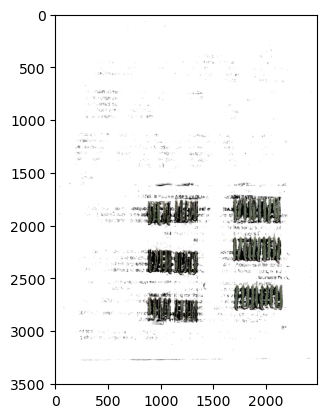

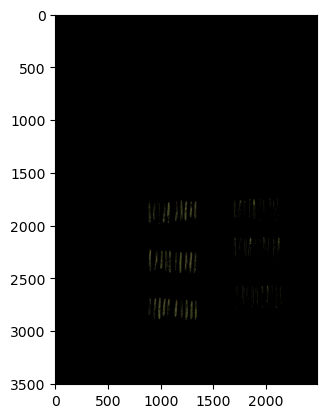

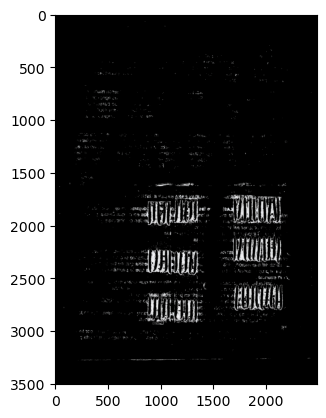

In [7]:
# We can apply each mask to the original image to more accurately 
# see what got masked

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
sana_img = pcv.apply_mask(mask=(mask['sanas']), img=img, mask_color='black')
enferma_img = pcv.apply_mask(mask=(mask['enfermas']), img=img, mask_color='black')
papel_img = pcv.apply_mask(mask=(mask['papel']), img=img, mask_color='black')


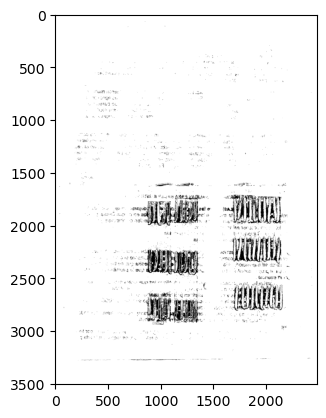

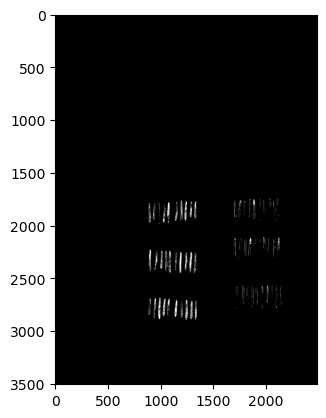

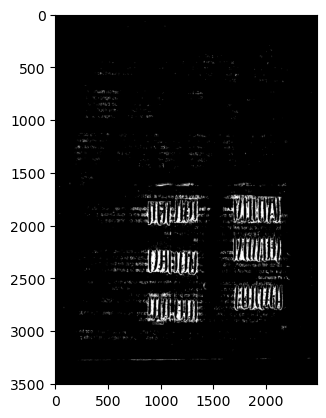

In [8]:
# Write image and mask with the same name to the path 
# specified (creates two folders within the path if they do not exist).

# Inputs: 
#   img - RGB or grayscale image data, original image 
#   mask - Binary mask image created 
#   filename - Image filename to get saved as
#   outdir - Output directory (default: None)
#   mask_only - Defaults to False, if True then only outputs mask 
sanas_maskpath, sanas_analysis_images = pcv.output_mask(img=img, mask=mask['sanas'], 
                                                        filename='sanas.png', mask_only=True)
enfermas_maskpath, enfermas_analysis_images = pcv.output_mask(img=img, mask=mask['enfermas'], 
                                                      filename='enfermas.png', mask_only=True)
papel_maskpath, papel_analysis_images = pcv.output_mask(img=img, mask=mask['papel'], 
                                                        filename='papel.png', mask_only=True)



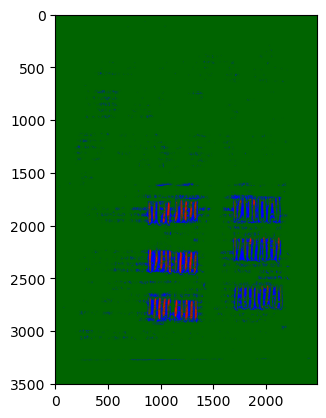

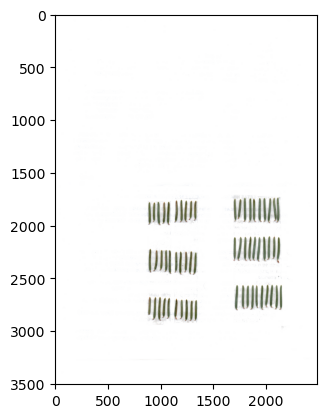

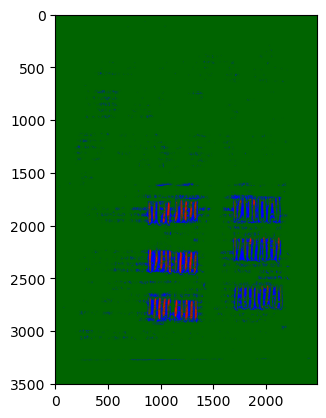

In [9]:
# To see all of these masks together we can plot them with plant set to green,
# chlorosis set to gold, and pustule set to red.

# Inputs:
#   masks - List of masks (the different classes returned by naive_bayes_classifier)
#   colors - List of colors to assign to each class. Users can either provide a 
#   list of color names (str) or can provide tuples of custom BGR values
classified_img = pcv.visualize.colorize_masks(masks=[mask['sanas'], mask['enfermas'], 
                                                     mask['papel']], 
                                              colors=['dark green', 'red', 'blue'])

classified_img_export = pcv.output_mask(img=img, mask= classified_img, 
                                                        filename='segmentadas.png')

In [10]:
import numpy as np

# Calculate percent of the plant found to be diseased 
sick_plant = np.count_nonzero(mask['enfermas']) #+ np.count_nonzero(mask['papel'])
healthy_plant = np.count_nonzero(mask['sanas'])
percent_diseased = sick_plant / (sick_plant + healthy_plant)
percent_diseased


0.007305203810927252

In [ ]:
# Create a new measurement (gets saved to the outputs class) 

# Inputs:
#    sample - A sample name or label
#    variable - The name of the variable for the observation to get stored. Must be unique to other variable names
#               since data is a dictionary format where variable is the key.
#    trait - Description of the observation getting stored
#    method - Description of the method for calculating the observation
#    scale - Observation scale
#    datatype - The datatype of the observation, most commonly either bool, str, int, float, list 
#    value - Value of the observation getting stored
#    label - Label for the observation getting stored. Required for list datatype observations. 
pcv.outputs.add_observation(sample='default', variable='percent_diseased', trait='percent of plant detected to be diseased',
                            method='ratio of pixels', scale='percent', datatype=float,
                            value=percent_diseased, label='percent')



In [ ]:
# Data stored to the outputs class can be accessed using the variable name
pcv.outputs.observations['default']['percent_diseased']['value']


In [ ]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 
pcv.outputs.save_results(filename=args.result)


To view and/or download the text file output (saved in JSON format)...
1) To see the text file with data that got saved out, click “File” tab in top left corner.
2) Click “Open…”
3) CLick on the file named “ml_tutorial_results.txt”

Check out documentation on how to [convert JSON](https://plantcv.readthedocs.io/en/latest/tools/#convert-output-json-data-files-to-csv-tables) format output into table formatted output. Depending on the analysis steps a PlantCV user may have two CSV files (single value traits and multivalue traits). 
